In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import nltk
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score
from sklearn.preprocessing import StandardScaler


IMPORT DATA AND DATA ANALYSIS

In [172]:
df=pd.read_csv('Resume.csv')
df.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [173]:
df.shape

(2484, 4)

In [174]:
valcounts=df['Category'].value_counts()
print(valcounts)

Category
INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      120
FINANCE                   118
ADVOCATE                  118
ACCOUNTANT                118
ENGINEERING               118
CHEF                      118
AVIATION                  117
FITNESS                   117
SALES                     116
BANKING                   115
HEALTHCARE                115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
Name: count, dtype: int64


In [175]:
df['Resume_str'][2000]

'         ASSISTANT PROJECT MANAGER/DESIGN BUILD CONSTRUCTION COORDINATOR       Summary     Highly motivated Civil Engineer with 16 years of experience working for one of North America\'s largest and most respected construction and engineering organizations with revenues of more than $11 billion and consistently ranking among the top five contractors by Engineering News-Record.   My experience with Kiewit has prepared me to successfully plan and execute projects while promoting safety, quality, schedule, and cost performance. My career experience ranges from construction design coordinator on a multi billion dollar design build project, to on-site project engineering and project management for self-performing heavy civil construction work ranging from $545 million to $3.1 million dollars. Excellent communicator skilled in construction means and methods, cost controls, scheduling, claims analysis and contract administration.   As the Field Engineer and Project Controls Manager on one of

In [176]:
# List job categories to drop
jobs_to_remove = ["CONSULTANT"]

# Get indexes of rows with those job categories
indexes_to_drop = df[df['Category'].isin(jobs_to_remove)].index

# Drop them
df = df.drop(indexes_to_drop).reset_index(drop=True)


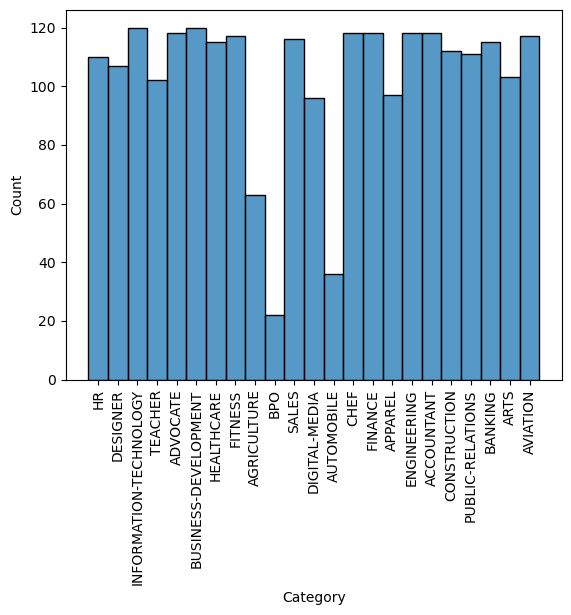

In [177]:
plt.figure()
sns.histplot(df['Category'])
plt.xticks(rotation=90)
plt.show()

DATA CLEANING

In [178]:
missingval=df.isnull().any()
print(missingval)

ID             False
Resume_str     False
Resume_html    False
Category       False
dtype: bool


In [179]:
import re

def clean_data(data):
    data = re.sub(r'http\S+\s*', ' ', data)  # Remove URLs
    data = re.sub(r'#\S+', '', data)         # Remove hashtags
    data = re.sub(r'@\S+', ' ', data)         # Remove mentions
    data = re.sub(r'[^\w\s]', ' ', data)      # Remove punctuation
    data = re.sub(r'[^\x00-\x7f]', r' ', data) # Remove non-ASCII chars
    data = re.sub(r'\s+', ' ', data)   # Replace multiple spaces with single space
    data = re.sub(r'\d+', '', data) 
    return data.strip()

# Apply cleaning
df['cleaned'] = df['Resume_str'].str.replace(r'\r\n', ' ', regex=True).str.lower()
df['cleaned'] = df['cleaned'].apply(clean_data)


In [180]:
df.head()

,ID,Resume_str,Resume_html,Category,cleaned
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR,hr administrator marketing associate hr admini...
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR,hr specialist us hr operations summary versati...
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR,hr director summary over years experience in ...
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR,hr specialist summary dedicated driven and dyn...
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR,hr manager skill highlights hr skills hr depar...


In [181]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')
df['cleaned']=df['cleaned'].apply(lambda x: word_tokenize(x))
#source: https://towardsdatascience.com/tokenize-text-columns-into-sentences-in-pandas-2c08bc1ca790/

[nltk_data] Downloading package punkt to /home/7b3aefbc-
[nltk_data]     aec7-488d-8f3c-a6537a9d26f0/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [182]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

df['cleaned'] = df['cleaned'].apply(lambda words: [lemmatizer.lemmatize(w) for w in words])


[nltk_data] Downloading package wordnet to /home/7b3aefbc-
[nltk_data]     aec7-488d-8f3c-a6537a9d26f0/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [183]:
from nltk.corpus import stopwords
from sklearn.feature_extraction import text

nltk.download('stopwords')
stop_words=set(stopwords.words('english'))
sklearn_stopwords = text.ENGLISH_STOP_WORDS
#Custom words to remove
custom_stopwords = {'company', 'skill', 'experience', 'resume', 'work', 'project', 'team', 'responsibility', 'summary', 'education', 'city', 'work', 'name', 
                   'training', 'year', 'time', 'including', 'maintained', 'support', 'current', 'development','state', 'new', 'office', 'professional','staff', 'procedure','process',
                   'program', 'activity', 'knowledge', 'daily', 'member', 'high', 'information', 'relation','highlight','dec', '2012', 'provided', 'goal', 'employee', '2014','need', 'various', 'project', 'assistant', 'manager', 'execute', 'control','update',
                   'specialist', 'director', 'supervisor', 'clerk', 'record', 'department', 'january', 'associate','product','school', 'managed', 'assisted', 'worked', 'excellent', 'strategy', 'service', 'developed', 'customer', 'plan', 'university', 'problem', 'performance', 'issue', 'ensure', 'operation',
                   'client', 'policy', 'responsible','planning', 'leadership', 'meeting', 'report', 'quality', 'material', 'relationship', 'maintained', 'area', 'created', 'order', 'level', 'wa', 'provide', 'using', 'strong', 'standard', 'maintain', 'general', 'monthly', 'student', 'inventory', 'item', 'schedule', 'community'}
combined_stopwords = stop_words.union(sklearn_stopwords).union(custom_stopwords)

def remove_stopwords(words):
    return [w for w in words if w not in combined_stopwords]
df['cleaned']=df['cleaned'].apply(remove_stopwords)  




#citation https://towardsdatascience.com/text-pre-processing-stop-words-removal-using-different-libraries-f20bac19929a/

[nltk_data] Downloading package stopwords to /home/7b3aefbc-
[nltk_data]     aec7-488d-8f3c-a6537a9d26f0/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [184]:
# Define words you want to remove (for teachers only)
teacher_words = {'art'}

# Function to remove those words
def remove_words_teacher(text, category, bad_words):
    if category == 'TEACHER':
       return [w for w in text if w not in bad_words]
    else:
        return text

# Apply the function
df['cleaned'] = df.apply(lambda row: remove_words_teacher(row['cleaned'], row['Category'], teacher_words), axis=1)

art_words = {'technology', 'student', 'event', 'teacher', 'sale'}

# Function to remove those words
def remove_words_art(text, category, bad_words):
    if category == 'ARTS':
       return [w for w in text if w not in bad_words]
    else:
        return text

# Apply the function
df['cleaned'] = df.apply(lambda row: remove_words_art(row['cleaned'], row['Category'], art_words), axis=1)



In [185]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
df['encoded_category']=le.fit_transform(df['Category'])
label_mapping=dict(zip(le.classes_, le.transform(le.classes_)))
print(label_mapping)
df.head()
#source: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html


{'ACCOUNTANT': 0, 'ADVOCATE': 1, 'AGRICULTURE': 2, 'APPAREL': 3, 'ARTS': 4, 'AUTOMOBILE': 5, 'AVIATION': 6, 'BANKING': 7, 'BPO': 8, 'BUSINESS-DEVELOPMENT': 9, 'CHEF': 10, 'CONSTRUCTION': 11, 'DESIGNER': 12, 'DIGITAL-MEDIA': 13, 'ENGINEERING': 14, 'FINANCE': 15, 'FITNESS': 16, 'HEALTHCARE': 17, 'HR': 18, 'INFORMATION-TECHNOLOGY': 19, 'PUBLIC-RELATIONS': 20, 'SALES': 21, 'TEACHER': 22}


,ID,Resume_str,Resume_html,Category,cleaned,encoded_category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR,"[hr, administrator, marketing, hr, administrat...",18
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR,"[hr, u, hr, versatile, medium, background, com...",18
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR,"[hr, recruiting, plus, human, resource, execut...",18
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR,"[hr, dedicated, driven, dynamic, expertise, mo...",18
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR,"[hr, hr, hr, startup, organization, startup, e...",18


MORE DATA ANALYSIS --MOST COMMON WORDS

In [186]:
all_words = []
for i in df['cleaned']:
    all_words.extend(i)
from collections import Counter
word_freq = Counter(all_words)
print("Most Common Words: ",word_freq.most_common(20)) 
#source: https://docs.python.org/3/library/collections.html

Most Common Words:  [('management', 11388), ('sale', 8007), ('business', 7413), ('account', 4394), ('marketing', 4226), ('financial', 4021), ('communication', 3548), ('data', 3506), ('design', 3457), ('analysis', 2892), ('budget', 2800), ('accounting', 2700), ('microsoft', 2652), ('software', 2456), ('equipment', 2379), ('medium', 2242), ('event', 2228), ('food', 2205), ('patient', 2157), ('technology', 2150)]


In [187]:
finance_words = []

for index, row in df.iterrows():
    if row['Category'] == "SALES":
        finance_words.extend(row['cleaned'])

from collections import Counter
word_freq = Counter(finance_words)
print(word_freq.most_common(20)) 

[('sale', 1385), ('management', 370), ('store', 318), ('business', 263), ('communication', 199), ('cash', 194), ('marketing', 183), ('account', 180), ('merchandise', 177), ('food', 124), ('organized', 110), ('credit', 107), ('retail', 102), ('manner', 98), ('payment', 97), ('equipment', 97), ('environment', 96), ('data', 94), ('question', 93), ('duty', 93)]


In [188]:
accounting_words = []

for index, row in df.iterrows():
    if row['Category'] == "AUTOMOBILE":
        accounting_words.extend(row['cleaned'])

from collections import Counter
word_freq = Counter(accounting_words)
print(word_freq.most_common(20)) 

[('management', 164), ('data', 132), ('claim', 127), ('sale', 104), ('business', 94), ('account', 74), ('tibco', 66), ('mdm', 61), ('application', 60), ('insurance', 57), ('analysis', 50), ('communication', 48), ('design', 47), ('database', 44), ('requirement', 44), ('technical', 40), ('representative', 40), ('center', 40), ('software', 38), ('phone', 38)]


VECTORIZATION OF DATA TO TRAIN MODEL

In [189]:
from sklearn.feature_extraction.text import TfidfVectorizer 

df['cleaned']=df['cleaned'].apply(lambda words: " ".join(words))

text=df['cleaned'].values
word_vectorizer=TfidfVectorizer(max_features=3000, ngram_range=(1, 2), max_df=0.8)
v_resume=word_vectorizer.fit_transform(df['cleaned'])


In [190]:
feature_names=word_vectorizer.get_feature_names_out()
vector=v_resume.todense().tolist()[0]
tfidf_scores=pd.DataFrame({
    'Word': feature_names,
    'Score':vector
})
tfidf_scores = tfidf_scores[tfidf_scores['Score'] > 0]

# Sort by score descending
tfidf_scores = tfidf_scores.sort_values(by='Score', ascending=False)

print(tfidf_scores)

                Word     Score
1706       marketing  0.336352
1747         medical  0.241876
318          billing  0.182237
2755     terminology  0.172744
1355              hr  0.160584
...              ...       ...
2516          senior  0.027724
799           design  0.026135
571         computer  0.025980
817          develop  0.025904
16    accomplishment  0.024273

[206 rows x 2 columns]


In [191]:
X = v_resume
y = df['encoded_category']

!pip uninstall -y scikit-learn imbalanced-learn

# Install specific compatible versions
!pip install scikit-learn==1.2.2
!pip install imbalanced-learn==0.10.1

# Import SMOTE after updating packages
from imblearn.over_sampling import SMOTE

# Now use SMOTE for oversampling
sm = SMOTE(random_state=23)
X, y = sm.fit_resample(X, y)
#SOURCE:https://www.geeksforgeeks.org/smote-for-imbalanced-classification-with-python/

Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Found existing installation: imbalanced-learn 0.10.1
Uninstalling imbalanced-learn-0.10.1:
ERROR: Exception:
Traceback (most recent call last):
  File "/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/shutil.py", line 825, in move
    os.rename(src, real_dst)
OSError: [Errno 18] Invalid cross-device link: '/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/imbalanced_learn-0.10.1.dist-info/' -> '/tmp/pip-uninstall-y9pgupbi'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/pip/_internal/cli/base_command.py", line 180, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/pip/_internal/c

In [233]:
from sklearn.utils import resample

# Define the maximum count among all categories
max_count = df['Category'].value_counts().max()

# Resample each category to match the maximum count
balanced_data = []
for category in df['Category'].unique():
    category_data = df[df['Category'] == category]
    if len(category_data) < max_count:
        # Perform oversampling for categories with fewer samples
        balanced_category_data = resample(category_data, replace=True, n_samples=max_count, random_state=42)
    else:
        # Perform undersampling for categories with more samples
        balanced_category_data = resample(category_data, replace=False, n_samples=max_count, random_state=42)
    balanced_data.append(balanced_category_data)

# Concatenate the balanced data for all categories
balanced_df = pd.concat(balanced_data)

balanced_df.head()

,ID,Resume_str,Resume_html,Category,cleaned,encoded_category,ExtractedSkills,title,new_feature
102,10399912,HR PERSONNEL ASSISTANT Summar...,"<div class=""fontsize fontface vmargins hmargin...",HR,hr personnel u citizen authorized u employer i...,18,typing word,hr personnel u citizen authorized u employer i...,hr personnel u citizen authorized u employer i...
51,39650734,HR ASSISTANT Summary Har...,"<div class=""fontsize fontface vmargins hmargin...",HR,hr hard worker dedicated detailed oriented exp...,18,professional communication skills and interper...,hr hard worker dedicated detailed oriented exp...,hr hard worker dedicated detailed oriented exp...
92,23510685,GLOBAL HR MANAGER Summary ...,"<div class=""fontsize fontface vmargins hmargin...",HR,global hr global hr progressive industry geogr...,18,adobe acrobat analyst architect balance basic ...,global hr global hr progressive industry geogr...,global hr global hr progressive industry geogr...
14,27490876,HR COORDINATOR Summary App...,"<div class=""fontsize fontface vmargins hmargin...",HR,hr coordinator applicant screening background ...,18,administrative ad arbitration agency budget co...,hr coordinator applicant screening background ...,hr coordinator applicant screening background ...
106,24402267,DESIGNATION: HR ASSISTANT Profe...,"<div class=""fontsize fontface vmargins hmargin...",HR,designation hr human resource coordination man...,18,hris iso recruitment performance appraisal tra...,designation hr human resource coordination man...,designation hr human resource coordination man...


SPLIT TRAINING SET

In [192]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

KNN CLASSIFIER

In [193]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=9)

knn.fit(X_train, y_train)

y_pred_knn=knn.predict(X_test)

In [194]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn))
accuracy=accuracy_score(y_test,y_pred_knn)
print("Overall Accuracy: {:.2f}%".format(accuracy * 100))


Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.91      0.72        23
           1       0.67      0.13      0.22        30
           2       0.47      0.67      0.55        24
           3       0.18      0.22      0.20        18
           4       0.43      0.25      0.32        24
           5       0.21      0.93      0.35        30
           6       0.83      0.24      0.37        21
           7       0.50      0.04      0.07        25
           8       0.16      1.00      0.28        18
           9       0.75      0.17      0.27        18
          10       0.81      0.57      0.67        23
          11       0.87      0.69      0.77        29
          12       0.86      0.75      0.80        24
          13       0.71      0.60      0.65        20
          14       1.00      0.41      0.59        29
          15       0.86      0.25      0.39        24
          16       0.92      0.52      0.67        23
   

ANALYZING WRONG PREDICTIONS TO FIGURE OUT HOW TO IMPROVE

In [195]:
wrong=y_test!=y_pred_knn
actual = le.inverse_transform(y_test[wrong])
predicted = le.inverse_transform(y_pred_knn[wrong])

wrong_df = pd.DataFrame({
    'Actual': actual,
    'Predicted': predicted
})

wrong_df.head(30)



,Actual,Predicted
0,BANKING,ACCOUNTANT
1,ADVOCATE,ARTS
2,INFORMATION-TECHNOLOGY,BPO
3,TEACHER,APPAREL
4,ADVOCATE,AGRICULTURE
5,BANKING,AUTOMOBILE
6,AVIATION,AUTOMOBILE
7,INFORMATION-TECHNOLOGY,AUTOMOBILE
8,CHEF,AUTOMOBILE
9,CONSTRUCTION,AUTOMOBILE


In [196]:
results=[]

for i in range(len(wrong_df)):
    if wrong_df.iloc[i]['Actual'] in ['ACCOUNTANT']:
        actual = wrong_df.iloc[i]['Actual']  
        predicted = wrong_df.iloc[i]['Predicted']
        results.append((actual, predicted))

results.sort(key=lambda x: x[0])
for actual, predicted in results:
    print(f"Actual: {actual}, Predicted: {predicted}")

Actual: ACCOUNTANT, Predicted: AGRICULTURE
Actual: ACCOUNTANT, Predicted: FINANCE


In [197]:
# KNN using Cosine Similarity
knn_cosine = KNeighborsClassifier(n_neighbors=11, metric='cosine')

# Fit on the training data
knn_cosine.fit(X_train, y_train)

# Predict
y_pred_cosine = knn_cosine.predict(X_test)

In [198]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred_cosine))
accuracy=accuracy_score(y_test,y_pred_cosine)
print("Overall Accuracy: {:.2f}%".format(accuracy * 100))



Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.91      0.69        23
           1       0.74      0.47      0.57        30
           2       0.83      0.62      0.71        24
           3       0.27      0.33      0.30        18
           4       0.55      0.25      0.34        24
           5       0.67      0.93      0.78        30
           6       0.67      0.57      0.62        21
           7       0.82      0.56      0.67        25
           8       0.46      1.00      0.63        18
           9       0.41      0.39      0.40        18
          10       0.71      0.65      0.68        23
          11       0.85      0.79      0.82        29
          12       0.84      0.88      0.86        24
          13       0.70      0.80      0.74        20
          14       0.72      0.62      0.67        29
          15       0.62      0.42      0.50        24
          16       0.68      0.57      0.62        23
   

RANDOM FOREST TRAINING

In [199]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(n_estimators=275, criterion='gini')
rf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=275)

In [200]:
y_pred_rf = rf.predict(X_test)

print(y_pred_rf)

[22 10 15  6 17 16 18 14 22  5  0  1  7  6 18 19 10  5  5 17 11  4  2 11
 10 11  5 16 15 21  1 14  0  9  5 10 21 22  2 11  1 21 16  1  2 14 12 12
 19  1 13 20 12  5 12 14 10 12 11  0 20 13 18 18  0 19 15 19  0 13  9 16
 18 14  9  3  6 22  6  1 11 22  8 11 14 17 15 15 15 14 11  2  3 16  8  2
  2  4  7 10  7 17 18 22 19  6  9 22 15  1  7 19 16  5  3 14 17 18 17  5
 14  4  6 13 10  0 15  5 11 17 15 12  4  9 19  9 12  4 18  3  7 14  9 10
 20 17  3 18 18 19 21  1  1 13  5 17 13  9  6  0 19 10 17  7 22  8 15 19
  1 13  5  2 13 13  7 18  5  7  2 12 18 12 16 22 10  5 12 20  7  0 10  8
 17 12  0 21 20 19  4 13 10  3  9 13  4 14 13 22  1 14  9 15 14 13  2  2
  0 22  3 19  2  1  6 10  5 19  0 16 15  4 18  0  3  8 11 20 17  1 16 17
  5 17  8 10 12  8 22  1 12  7 21 15 16  7 15  8 17 20  6 11 12 12 18 18
  5  5 19  8 16 20 20  6 12  8 20 22 14 11 17 12 10 16  2  6 14  2 13 12
 13 19 14 13 16 12 21  2  6 13  5 21 12 13 20 19  8 21 15 10  1 10 22 22
 19 11 12 11  6 19  1 11 21 12 21 11  0 19  4 22 12

In [201]:
# Print a detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# Print overall accuracy
accuracy = accuracy_score(y_test, y_pred_rf)
print("Overall Accuracy: {:.2f}%".format(accuracy * 100))


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.96      0.85        23
           1       0.92      0.73      0.81        30
           2       1.00      0.79      0.88        24
           3       0.80      0.67      0.73        18
           4       0.83      0.62      0.71        24
           5       0.97      0.97      0.97        30
           6       0.90      0.90      0.90        21
           7       0.90      0.76      0.83        25
           8       1.00      1.00      1.00        18
           9       0.43      0.33      0.38        18
          10       0.79      0.83      0.81        23
          11       0.93      0.90      0.91        29
          12       0.77      0.96      0.85        24
          13       0.71      0.85      0.77        20
          14       0.73      0.83      0.77        29
          15       0.68      0.71      0.69        24
          16       0.81      0.74      0.77        23
   

In [202]:
feature_names = word_vectorizer.get_feature_names_out()  # For newer scikit-learn versions
# OR feature_names = vectorizer.get_feature_names()  # For older scikit-learn versions

# 2. Finding the most important features in the random forest model
importances = rf.feature_importances_

# 3. Create a DataFrame with feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 4. Print the top features
print(feature_importance_df.head(10))  # Show top 10 most important features

           Feature  Importance
805       designer    0.011644
1146       fitness    0.009992
609   construction    0.009940
265       aviation    0.009300
968    engineering    0.008885
2734       teacher    0.008710
106       advocate    0.008682
1312    healthcare    0.007829
1355            hr    0.007561
2430          sale    0.006964


In [203]:
wrong=y_test!=y_pred_rf
actual = le.inverse_transform(y_test[wrong])
predicted = le.inverse_transform(y_pred_rf[wrong])

wrong_df = pd.DataFrame({
    'Actual': actual,
    'Predicted': predicted
})

wrong_df.head(30)

valcounts=wrong_df['Actual'].value_counts()
print(valcounts)

results=[]

Actual
SALES                     15
BUSINESS-DEVELOPMENT      12
HEALTHCARE                 9
ARTS                       9
ADVOCATE                   8
FINANCE                    7
BANKING                    6
FITNESS                    6
APPAREL                    6
AGRICULTURE                5
ENGINEERING                5
INFORMATION-TECHNOLOGY     4
CHEF                       4
HR                         3
DIGITAL-MEDIA              3
CONSTRUCTION               3
AVIATION                   2
TEACHER                    2
PUBLIC-RELATIONS           1
ACCOUNTANT                 1
AUTOMOBILE                 1
DESIGNER                   1
Name: count, dtype: int64


In [204]:
results=[]

for i in range(len(wrong_df)):
    if wrong_df.iloc[i]['Actual'] in ['ARTS']:
        actual = wrong_df.iloc[i]['Actual']  
        predicted = wrong_df.iloc[i]['Predicted']
        results.append((actual, predicted))

results.sort(key=lambda x: x[0])
for actual, predicted in results:
    print(f"Actual: {actual}, Predicted: {predicted}")

Actual: ARTS, Predicted: BUSINESS-DEVELOPMENT
Actual: ARTS, Predicted: PUBLIC-RELATIONS
Actual: ARTS, Predicted: INFORMATION-TECHNOLOGY
Actual: ARTS, Predicted: HEALTHCARE
Actual: ARTS, Predicted: INFORMATION-TECHNOLOGY
Actual: ARTS, Predicted: CHEF
Actual: ARTS, Predicted: DESIGNER
Actual: ARTS, Predicted: FITNESS
Actual: ARTS, Predicted: HR


In [234]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=3000, ngram_range=(1,2), stop_words='english', min_df=5, max_df=0.8)

# 2. Learn vocabulary + transform text
X = vectorizer.fit_transform(balanced_df['cleaned'])
y=balanced_df['encoded_category']
# 3. Train a model (e.g., Naive Bayes)
sm = SMOTE(random_state=23)
#X, y = sm.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from sklearn.naive_bayes import MultinomialNB



In [235]:

model =MultinomialNB()
model.fit(X_train, y_train)
y_pred_nb = model.predict(X_test)

In [236]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred_nb))

# Print overall accuracy
accuracy = accuracy_score(y_test, y_pred_nb)
print("Overall Accuracy: {:.2f}%".format(accuracy * 100))




Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.92      0.79        25
           1       0.56      0.56      0.56        25
           2       0.94      0.59      0.73        27
           3       0.78      0.69      0.73        26
           4       1.00      0.43      0.61        23
           5       1.00      0.75      0.86        20
           6       0.78      0.84      0.81        25
           7       0.93      0.59      0.72        22
           8       1.00      0.92      0.96        26
           9       0.52      0.70      0.60        20
          10       0.87      0.87      0.87        30
          11       0.95      0.69      0.80        26
          12       0.85      0.82      0.84        28
          13       0.71      0.83      0.77        24
          14       0.74      0.78      0.76        18
          15       0.94      0.74      0.83        23
          16       0.79      0.68      0.73        22
   

In [208]:
wrong=y_test!=y_pred_rf
actual = le.inverse_transform(y_test[wrong])
predicted = le.inverse_transform(y_pred_rf[wrong])

wrong_df = pd.DataFrame({
    'Actual': actual,
    'Predicted': predicted
})

wrong_df.head(30)

valcounts=wrong_df['Actual'].value_counts()
print(valcounts)

results=[]

Actual
SALES                     15
BUSINESS-DEVELOPMENT      12
HEALTHCARE                 9
ARTS                       9
ADVOCATE                   8
FINANCE                    7
BANKING                    6
FITNESS                    6
APPAREL                    6
AGRICULTURE                5
ENGINEERING                5
INFORMATION-TECHNOLOGY     4
CHEF                       4
HR                         3
DIGITAL-MEDIA              3
CONSTRUCTION               3
AVIATION                   2
TEACHER                    2
PUBLIC-RELATIONS           1
ACCOUNTANT                 1
AUTOMOBILE                 1
DESIGNER                   1
Name: count, dtype: int64


In [209]:
# Get class-conditional probabilities
feature_names = vectorizer.get_feature_names_out()
class_labels = le.classes_

# See top words per class
for i, class_label in enumerate(class_labels):
    top10 = np.argsort(model.feature_log_prob_[i])[-10:]
    print(f"\nClass: {class_label}")
    for j in top10:
        print(f"{feature_names[j]} ({np.exp(model.feature_log_prob_[i][j]):.4f})")



Class: ACCOUNTANT
analysis (0.0069)
payroll (0.0070)
reconciliation (0.0076)
business (0.0077)
statement (0.0078)
tax (0.0089)
accountant (0.0101)
account (0.0192)
financial (0.0204)
accounting (0.0229)

Class: ADVOCATE
data (0.0034)
medical (0.0035)
account (0.0045)
health (0.0045)
advocate (0.0052)
child (0.0054)
business (0.0056)
care (0.0060)
patient (0.0071)
sale (0.0089)

Class: AGRICULTURE
college (0.0036)
communication (0.0042)
safety (0.0045)
public (0.0045)
health (0.0049)
business (0.0055)
data (0.0062)
science (0.0070)
agriculture (0.0072)
research (0.0077)

Class: APPAREL
fashion (0.0039)
merchandising (0.0043)
cash (0.0046)
production (0.0048)
merchandise (0.0049)
marketing (0.0057)
design (0.0065)
business (0.0084)
store (0.0143)
sale (0.0211)

Class: ARTS
parent (0.0033)
design (0.0034)
child (0.0035)
teaching (0.0035)
classroom (0.0035)
english (0.0041)
marketing (0.0041)
communication (0.0042)
learning (0.0044)
art (0.0211)

Class: AUTOMOBILE
application (0.0042)
pho

In [237]:
new_resume="hr assistant summary hard worker dedicated detailed oriented experienced organized highly motivated many attributes possess individual years experience human resource administration customer service talent quickly adapt new challenges experience focused benefits administration payroll career development employment law highlights assigned administrative assignments daily basis implemented employee handbook processed documentation employees conducted employees performance reviews managed employee scheduling coordinated upper level co worker lower level teamwork oriented processed new recruits processed payroll performed check managed inventory supplies secured new wholesale food purveyor decrease costs increase profits accomplishments accomplishments pho n restaurant managed restaurant financial objectives developing financing establishing banking relationships prepared strategic annual forecasts budgets analyzing variances initiating corrective actions establishing financial controls developed implemented strategies increase average meal checks created restaurant business plan surveying restaurant demand conferring people community identifying evaluating competitors preparing financial marketing sales projections analyses estimates controlled purchases inventory meeting account manager negotiating prices contracts developing preferred supplier lists reviewing evaluating usage reports analyzing variances taking corrective actions contributed team effort inspired team members motivation provided high level customer service maintain high profile day day operations handled complaints contentious issues settled directly team members provides fast solution accomplished campaign recycle program divide right trash right bin accomplishments dr norman g mckoy associates demonstrated success administrative employee handbook developing team building programs corporate policies job descriptions management reports organized office documents patients charts organized office woking areas welcomed new employees organization conducting orientation organized employees document pockets maintained employees confidence protect operation keeping human resource information confidential maintained employee information entering updating employment status change data provided payroll information collecting time attendance records provided secretarial support entering formatting printing information organizing work answering telephone relaying messages maintaining equipment supplies experience company name city state hr assistant increased productivity physician office organizing patients charts converting digital files streamline patient maintenance processed pay roll paychex includes ensured vacation sick time tracked system answered payroll questions facilited resolutions payroll errors processed incoming mails going mails successfully edited employee handbook define job descriptions create office policies patient managing proper patient reports wrote employee handbook covering issues including disciplinary procedures code conduct fmla policy benefits information wrote standard operations procedures manual sops detailed aspect employee expectations designed implement overall recruiting strategy coordinated office manager recruit right candidates administering interviews conducting background checks processed documentation prepared reports relating personnel activities staffing recruitment training performance evaluations etc identified reduced business expenses increase profits controlling budget compares actual results budget expectations company name city state general manager current hostess waitress promoted interview recruit new hires order sustain longer hours operation thus increased company profitswas successful ensuring successful integration new hires implementing training compensation structures ordered foods supplies restaurant checked maintained inventory handling daily accounting processing payroll processed cost reduction thought venders whole sale increased marketability restaurant designing creating new modernized menu prepared willing step restaurant short staff low turn order increase productivity provide best service maintained great quality quantity foods restaurant created recycle program divided recyclable bin non recyclable waste bin education bachelor arts humanities english university thai chamber commerce city thailand humanities english excelled language culture transportation management critical reading article writing advanced technical reading master science human resource management strayer university city state usa human resource management magna cum laude excelled human resources law management ethical hr information systems hris strategic management registered professional human resources aphr certification hr designations registering aphr professional human resources exam expect complete aphr certification professional affiliations enrolling ongoing training areas compensation benefits employee labor relations leaves absence workers compensation workplace safety security member society human resource management shrm skills human resource management skills employment law hr policies procedures training development performance management employee relations mediation benefits administration orientation boarding organizational development staff life cycle computer skills hris applications peoplesoft enterprise human resources ms office word excel powerpoint access outlook e mailing tools ms outlook windows outlook yahoo google networking skills job boards networking sites soft skills professional communication skills interpersonal skills bilingual thai english excellent adaptability new environments hard working flexible reliable honest polite shape decision making excellent customer service skills creative"

def clean_text_for_prediction(text):
    text = re.sub(r'\d+', '', text)
    text = re.sub('http\\S+', ' ', text)
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~"""), ' ', text)
    text = re.sub(r'[^\x00-\x7f]', r' ', text)
    text = re.sub('\s+', ' ', text).strip()
    text = text.lower()
    
    # Remove stopwords
    words = text.split()
    words = [w for w in words if w not in combined_stopwords]
    return ' '.join(words)

cleaned_resume = clean_text_for_prediction(new_resume)


In [239]:
X_new = vectorizer.transform([new_resume])

# Predict
y_pred = rf.predict(X_new)

# Decode label
predicted_job = le.inverse_transform(y_pred)
print("Predicted Job Category:", predicted_job[0])

Predicted Job Category: CHEF


DATA SEGMENTATION

In [240]:

def extract_full_skills_list(text):
    # Find the last occurrence of the word 'skills'
    match = list(re.finditer(r'\bSkills\b', text))
    if match:
        start_idx = match[-1].end()
        after_skills = text[start_idx:].strip()

        # Grab everything up to the first double newline or end
        # This assumes the skills list is just a long comma-separated line
        skills_line = after_skills.split('\n')[0]  # just the first line
        return skills_line.strip(' .\n')
    return ''

# Apply to DataFrame
df['ExtractedSkills'] = df['Resume_str'].apply(extract_full_skills_list)


In [211]:
df.head()

,ID,Resume_str,Resume_html,Category,cleaned,encoded_category,ExtractedSkills
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR,hr administrator marketing hr administrator de...,18,"Accounting, ads, advertising, analytical skill..."
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR,hr u hr versatile medium background communicat...,18,"Adobe Photoshop, ADP, Asset Management, brandi..."
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR,hr recruiting plus human resource executive ma...,18,"Desktop Publishing, Newsletter productions, ..."
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR,hr dedicated driven dynamic expertise motivate...,18,"10-Key by touch, Type 50 wpm, filing, Access, ..."
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR,hr hr hr startup organization startup employme...,18,"ADA, ADP, art, agency, benefits, Benefits Admi..."


In [212]:
df['Resume_str'][5]

'         HR GENERALIST       Summary     Dedicated and focused Administrative Assistant who excels at prioritizing, completing multiple tasks simultaneously and following through to achieve project goals. Seeking a role of increased responsibility and authority.       Highlights         Microsoft Office proficiency  Excel spreadsheets  Meticulous attention to detail  Results-oriented  Self-directed      Time management  Professional and mature  Self-starter  Legal administrative support            Experience     11/2008   to   08/2014     HR Generalist    Company Name   －   City  ,   State      Managed visa related employment processes for all non-immigrant faculty and staff.  Improved productivity and enhanced visa related services.  Improved operational structure by developing guidelines and tools for internal and external administration of non-immigrant employment procedures  Reduced internal employment authorization processing times by approximately 30 percent.  Prepared, reviewed

In [213]:
df['ExtractedSkills'][5]

'administrative, Administrative Assistant, bi, conferences, database, special events, filing, Human Resource Management, HR, Human Resources Management, Excel, Exchange, Microsoft Office, Office, Outlook, PowerPoint, Word, newsletter, Paralegal, Performance Management, processes, Publications, Recruitment, Strategic Planning, Supervisor, training programs, travel arrangements, Visio, Website, workshops, annual reports'

In [214]:
df['ExtractedSkills'] = df['ExtractedSkills'].apply(lambda x:clean_data(x))

In [215]:
df['ExtractedSkills'] = df['ExtractedSkills'].str.replace(r'\r\n', ' ', regex=True).str.lower()

In [216]:
def extract_first_words(text, num_words=10):
    if isinstance(text, list):
        return ' '.join(text[:num_words])
    elif isinstance(text, str):
        return ' '.join(text.split()[:num_words])
    else:
        return ''
    
df['title'] = df['cleaned'].apply(lambda x: extract_first_words(x, num_words=10))



In [217]:
df['title'].head()

0    hr administrator marketing hr administrator de...
1    hr u hr versatile medium background communicat...
2    hr recruiting plus human resource executive ma...
3    hr dedicated driven dynamic expertise motivate...
4    hr hr hr startup organization startup employme...
Name: title, dtype: object

In [218]:
df['new_feature'] = df['title'] + ' ' + df['ExtractedSkills']
df.head()

,ID,Resume_str,Resume_html,Category,cleaned,encoded_category,ExtractedSkills,title,new_feature
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR,hr administrator marketing hr administrator de...,18,accounting ads advertising analytical skills b...,hr administrator marketing hr administrator de...,hr administrator marketing hr administrator de...
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR,hr u hr versatile medium background communicat...,18,adobe photoshop adp asset management branding ...,hr u hr versatile medium background communicat...,hr u hr versatile medium background communicat...
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR,hr recruiting plus human resource executive ma...,18,desktop publishing newsletter productions data...,hr recruiting plus human resource executive ma...,hr recruiting plus human resource executive ma...
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR,hr dedicated driven dynamic expertise motivate...,18,key by touch type wpm filing access microsoft...,hr dedicated driven dynamic expertise motivate...,hr dedicated driven dynamic expertise motivate...
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR,hr hr hr startup organization startup employme...,18,ada adp art agency benefits benefits administr...,hr hr hr startup organization startup employme...,hr hr hr startup organization startup employme...


In [219]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')
df['new_feature']=df['new_feature'].apply(lambda x: word_tokenize(x))

[nltk_data] Downloading package punkt to /home/7b3aefbc-
[nltk_data]     aec7-488d-8f3c-a6537a9d26f0/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [220]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

df['new_feature'] = df['new_feature'].apply(lambda words: [lemmatizer.lemmatize(w) for w in words])


[nltk_data] Downloading package wordnet to /home/7b3aefbc-
[nltk_data]     aec7-488d-8f3c-a6537a9d26f0/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [221]:
from nltk.corpus import stopwords
from sklearn.feature_extraction import text

nltk.download('stopwords')
stop_words=set(stopwords.words('english'))
sklearn_stopwords = text.ENGLISH_STOP_WORDS
#Custom words to remove
custom_stopwords = {'company', 'skill', 'experience', 'resume', 'work', 'project', 'team', 'responsibility', 'summary', 'education', 'city', 'work', 'name', 
                   'training', 'year', 'time', 'including', 'maintained', 'support', 'current', 'development','state', 'new', 'office', 'professional','staff', 'procedure','process',
                   'program', 'activity', 'knowledge', 'daily', 'member'}
combined_stop_words = stop_words.union(sklearn_stopwords).union(custom_stopwords)

def remove_stopwords(words):
    return [w for w in words if w not in combined_stop_words]
df['new_feature']=df['new_feature'].apply(remove_stopwords)  

[nltk_data] Downloading package stopwords to /home/7b3aefbc-
[nltk_data]     aec7-488d-8f3c-a6537a9d26f0/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [222]:
from sklearn.feature_extraction.text import TfidfVectorizer 

df['new_feature']=df['new_feature'].apply(lambda words: " ".join(words))

text=df['new_feature'].values
word_vectorizer=TfidfVectorizer(max_features=3000, ngram_range=(1, 2), max_df=0.8)
v_words=word_vectorizer.fit_transform(df['new_feature'])

In [223]:
X=v_words
y=df['encoded_category']
!pip install -U scikit-learn==1.2.2 imbalanced-learn==0.10.1
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 23)
X, y = sm.fit_resample(X, y)

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels


In [224]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [225]:
rf=RandomForestClassifier(n_estimators=300)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=300)

In [226]:
y_pred_rf = rf.predict(X_test)

In [227]:
# Print a detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# Print overall accuracy
accuracy = accuracy_score(y_test, y_pred_rf)
print("Overall Accuracy: {:.2f}%".format(accuracy * 100))


Classification Report:
              precision    recall  f1-score   support

           0       0.66      1.00      0.79        23
           1       0.95      0.67      0.78        30
           2       1.00      0.75      0.86        24
           3       0.67      0.44      0.53        18
           4       0.80      0.33      0.47        24
           5       0.89      0.80      0.84        30
           6       0.56      0.43      0.49        21
           7       0.93      0.52      0.67        25
           8       1.00      1.00      1.00        18
           9       0.33      0.67      0.44        18
          10       0.90      0.78      0.84        23
          11       0.74      0.86      0.79        29
          12       0.88      0.96      0.92        24
          13       0.79      0.75      0.77        20
          14       0.81      0.86      0.83        29
          15       0.72      0.75      0.73        24
          16       0.90      0.39      0.55        23
   

In [228]:
feature_names = word_vectorizer.get_feature_names_out()  # For newer scikit-learn versions
# OR feature_names = vectorizer.get_feature_names()  # For older scikit-learn versions

# 2. Finding the most important features in the random forest model
importances = rf.feature_importances_

# 3. Create a DataFrame with feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 4. Print the top features
print(feature_importance_df.head(10))  # Show top 10 most important features

           Feature  Importance
2740       teacher    0.019370
574   construction    0.017034
431           chef    0.015540
763       designer    0.015344
98        advocate    0.014153
905    engineering    0.013709
2419          sale    0.012025
1274            hr    0.011854
1053       finance    0.011134
22      accountant    0.011093


In [229]:
wrong=y_test!=y_pred_rf
actual = le.inverse_transform(y_test[wrong])
predicted = le.inverse_transform(y_pred_rf[wrong])

wrong_df = pd.DataFrame({
    'Actual': actual,
    'Predicted': predicted
})

wrong_df.head(30)

valcounts=wrong_df['Actual'].value_counts()
print(valcounts)

results=[]

Actual
ARTS                      16
FITNESS                   14
BANKING                   12
AVIATION                  12
HEALTHCARE                11
ADVOCATE                  10
APPAREL                   10
SALES                      7
INFORMATION-TECHNOLOGY     6
AGRICULTURE                6
AUTOMOBILE                 6
FINANCE                    6
BUSINESS-DEVELOPMENT       6
DIGITAL-MEDIA              5
CHEF                       5
ENGINEERING                4
CONSTRUCTION               4
PUBLIC-RELATIONS           3
HR                         2
DESIGNER                   1
Name: count, dtype: int64


In [230]:
print(df[df['Category'].isin(['ARTS', 'TEACHER'])]['new_feature'])



337     teacher master teacher looking role industry l...
338     teacher taught th nd rd grade typically collab...
339     teacher chart communication conference conflic...
340     teacher obtain position working utilize friend...
341     teacher e ducator people enthusiasti c solve r...
                              ...                        
2247    audio visual technician proficient configurati...
2248    executive secure position respected business b...
2249    administrative site career overview committed ...
2250    coordinator donor highly organized communicati...
2251    dental hygienist dedicated energetic dental hy...
Name: new_feature, Length: 205, dtype: object


In [231]:
from sklearn.naive_bayes import MultinomialNB
model =MultinomialNB()
model.fit(X_train, y_train)
y_pred_nb = model.predict(X_test)

In [232]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred_nb))

# Print overall accuracy
accuracy = accuracy_score(y_test, y_pred_nb)
print("Overall Accuracy: {:.2f}%".format(accuracy * 100))


Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.96      0.67        23
           1       0.65      0.37      0.47        30
           2       0.71      0.42      0.53        24
           3       0.54      0.39      0.45        18
           4       0.55      0.25      0.34        24
           5       0.79      0.63      0.70        30
           6       0.48      0.57      0.52        21
           7       0.80      0.48      0.60        25
           8       0.63      0.94      0.76        18
           9       0.26      0.56      0.36        18
          10       0.74      0.74      0.74        23
          11       0.83      0.69      0.75        29
          12       0.90      0.75      0.82        24
          13       0.56      0.75      0.64        20
          14       0.85      0.76      0.80        29
          15       0.67      0.42      0.51        24
          16       0.67      0.35      0.46        23
   